In [1]:
import numpy as np
import gym
import random
from collections import namedtuple,deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)

[0]

In [3]:
print(env.observation_space)
print(env.action_space.n)

Box(8,)
4


In [4]:
#parameter
batch_size = 64
max_capacity = int(1e5)
gamma = .99
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
UPDATE_EVERY = 4
LR = 5e-4
TAU = 1e-3

In [5]:
class Agent():
    def __init__(self, state_size, action_size, seed, implement = 'DDQN',implement_1 = 'Duelling'):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        if implement_1 == 'Duelling':
            self.local_net = DuellingQNetwork(state_size, action_size, seed).to(device)
            self.target_net = DuellingQNetwork(state_size, action_size, seed).to(device)
        else:
            self.local_net = QNetwork(state_size, action_size, seed).to(device)
            self.target_net = QNetwork(state_size, action_size, seed).to(device)
        self.memory = ReplayBuffer(batch_size, max_capacity, seed)
        self.optimizer = optim.Adam(self.local_net.parameters(),lr = LR)
        self.t_steps = 0
        self.implement = implement
        
    def epsilon_greedy(self,action_values,eps):    
        random_gen = random.uniform(0,1)
        if random_gen > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def act(self, state, eps = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_net.eval()
        with torch.no_grad():
            action_values = self.local_net(state)
#             print('Action Values : ',action_values)
#             print('Action Values size : ',action_values.shape)
        self.local_net.train()
        return self.epsilon_greedy(action_values,eps)
    
    def step(self,state,action,reward,next_state,done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_steps = (self.t_steps + 1) % UPDATE_EVERY
        if self.t_steps  == 0:     
            if len(self.memory) > batch_size:
                experiences = self.memory.sample()
                self.learn(experiences,gamma)
    
    def learn(self,experiences,gamma):
        
        states,actions,rewards,next_states,dones = experiences
        
        if self.implement == 'DQN':
            targeted_output_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
            
        if self.implement == 'DDQN':
            best_action_local = self.local_net(next_states).max(1)[1].unsqueeze(1)
            Q_target_values = self.target_net(next_states)
            targeted_output_next = torch.gather(Q_target_values,1,best_action_local) 
            
        target_totals = rewards + (gamma*targeted_output_next*(1-dones))
        local_outputs = self.local_net(states).gather(1,actions)
        
        loss = F.mse_loss(local_outputs,target_totals)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        #updating target_net
        self.update(self.local_net,self.target_net,TAU)
    
    def update(self,local_model,target_model,tau):
        
        for local_param,target_param in zip(local_model.parameters(),target_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [6]:
class QNetwork(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units = 64,fc2_units = 64):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,fc1_units)
        self.fc2 = nn.Linear(fc1_units,fc2_units)
        self.fc3 = nn.Linear(fc2_units,action_size)
        
    def forward(self,state):
        output = F.relu(self.fc1(state))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [7]:
class DuellingQNetwork(nn.Module):
    def __init__(self,state_size,action_size,seed,fc1_units= 64,fc2_units = 64):
        super(DuellingQNetwork,self).__init__()
        torch.manual_seed(seed)
        self.action_size = action_size
        self.fc_1 = nn.Linear(state_size,fc1_units)
        self.fc_2 = nn.Linear(fc1_units,fc2_units)
        self.value_fc = nn.Linear(fc2_units,1)
        self.action_fc = nn.Linear(fc2_units,action_size)
    
    def forward(self,state):
        x = F.relu(self.fc_1(state))
        x = F.relu(self.fc_2(x))
        
        value_function = self.value_fc(x)
        action_function = self.action_fc(x)
        
        temp = value_function + action_function - action_function.mean(dim = 1,keepdim = True).expand(x.size(0),self.action_size)
        return temp

In [8]:
class ReplayBuffer:
    def __init__(self,batch_size,max_capacity,seed):
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.buffer_size = max_capacity
        self.buffer = deque(maxlen = max_capacity)
        self.experience = namedtuple('Experiences',field_names = ['state','action','reward','next_state','done'])
    
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.buffer.append(e)
    
    def sample(self):
        batch = random.sample(self.buffer,k = self.batch_size)
        
        states = torch.from_numpy(np.vstack([b.state for b in batch if b is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([b.action for b in batch if b is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([b.reward for b in batch if b is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([b.next_state for b in batch if b is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([b.done for b in batch if b is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.buffer)

In [9]:
agent = Agent(state_size = 8, action_size = 4, seed = 0, implement = 'DDQN',implement_1 = 'Duelling')

In [10]:
state = env.reset()
for j in range(200):
    print(state)
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

[-5.9156417e-04  1.4134574e+00 -5.9935719e-02  1.1277095e-01
  6.9228926e-04  1.3576316e-02  0.0000000e+00  0.0000000e+00]
[-1.0364533e-03  1.4164169e+00 -4.5885697e-02  1.3153474e-01
  2.0719476e-03  2.7596612e-02  0.0000000e+00  0.0000000e+00]
[-1.3278008e-03  1.4193444e+00 -3.1279739e-02  1.3010892e-01
  4.1921693e-03  4.2408355e-02  0.0000000e+00  0.0000000e+00]
[-0.00180006  1.4230148  -0.04851371  0.16312443  0.00546235  0.02540583
  0.          0.        ]
[-0.00220442  1.4270576  -0.04207569  0.17967772  0.0070752   0.03226004
  0.          0.        ]
[-0.00250835  1.4319324  -0.03253763  0.21664539  0.00920047  0.04250934
  0.          0.        ]
[-0.00296211  1.4375173  -0.04684117  0.24820088  0.01064847  0.02896278
  0.          0.        ]
[-0.00351076  1.4435569  -0.05591135  0.26842055  0.01168062  0.02064514
  0.          0.        ]
[-0.00412664  1.4498497  -0.06234276  0.27967432  0.01242464  0.0148818
  0.          0.        ]
[-0.00460386  1.4566123  -0.04918569  

[-0.13048592  3.2972784  -0.23913062  1.4087452  -0.02354079 -0.21335995
  0.          0.        ]
[-0.13289471  3.3283694  -0.22776875  1.3815749  -0.03648794 -0.2589429
  0.          0.        ]
[-0.13523874  3.3602297  -0.22144344  1.4156517  -0.04928951 -0.25603124
  0.          0.        ]
[-0.13749877  3.391476   -0.21089658  1.3881402  -0.06421622 -0.29853427
  0.          0.        ]
[-0.1396822   3.42366    -0.20330472  1.4296893  -0.07909374 -0.2975509
  0.          0.        ]
[-0.14184341  3.4558043  -0.20106766  1.427767   -0.09400518 -0.2982287
  0.          0.        ]
[-0.14378385  3.4881465  -0.17980602  1.4364679  -0.10813071 -0.28251085
  0.          0.        ]
[-0.14553995  3.5206401  -0.16198811  1.4431243  -0.12165818 -0.27054933
  0.          0.        ]
[-0.14714375  3.5539763  -0.14695577  1.4804479  -0.1350267  -0.26737025
  0.          0.        ]
[-0.14865732  3.586702   -0.13566491  1.4529611  -0.1506771  -0.3130081
  0.          0.        ]
[-0.15000305  

Episode : 100	 Average Reward : -180.45
Episode : 200	 Average Reward : -155.55
Episode : 300	 Average Reward : -48.38
Episode : 400	 Average Reward : -12.88
Episode : 500	 Average Reward : 94.36
Episode : 600	 Average Reward : 177.86
Episode : 700	 Average Reward : 194.67
Episode : 800	 Average Reward : 199.56
Episode : 900	 Average Reward : 224.80
Episode : 912	 Average Score: 226.17
Environment solved in 812 episodes!	Average Score: 226.17


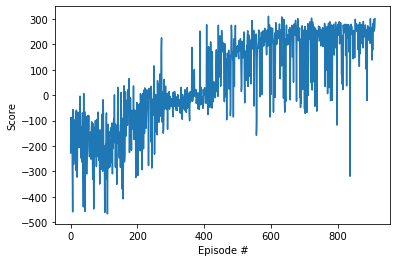

In [11]:
def DDDQN(n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_min = .01, eps_decay = 0.995, window = 100):
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=window)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        eps = max(eps*eps_decay,eps_min)
        scores.append(score)
        print('\rEpisode : {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode%100 == 0:
            print('\rEpisode : {}\t Average Reward : {:.2f}'.format(i_episode,np.mean(scores_window)))
        if np.mean(scores_window)>=225.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.local_net.state_dict(), 'checkpoint_1_1.pth')
            break
    return scores

scores = DDDQN()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [17]:
agent.local_net.load_state_dict(torch.load('checkpoint_1_1.pth'))
for i_episode in range(10):
    state = env.reset()
    rewards = 0
    for j in range(1000):
        action = agent.act(state)
        env.render()
        next_state,reward,done,_ = env.step(action)
        state = next_state
        rewards += reward
        if done:
            break
    print('\nReward per episode : {}'.format(rewards))

env.close()


Reward per episode : 299.5673845146365

Reward per episode : 16.79374858149751

Reward per episode : 246.47584082303732

Reward per episode : 270.91050743599976

Reward per episode : 210.95032020209948

Reward per episode : 245.42288477382453

Reward per episode : 277.50786667986756

Reward per episode : 285.0348597909578

Reward per episode : 293.2165110042635

Reward per episode : 261.30314807536934
